# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [4]:
# create symlink pointing to utils.py in project subfolder
!ln -s project/utils.py utils.py

ln: failed to create symbolic link 'utils.py': File exists


In [60]:
import os
import time
import logging
import collections
from glob import glob
from random import choice
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from PIL import ImageOps

from utils import get_dataset

In [14]:
# silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [6]:
# Helper functions for dataset loading

def make_data_path(path_to_tfrecords="project/data/processed/"):
    """Returns a list of all *.tfrecord files in the provided path

    Args:
        - path_to_tfrecords (str, optional): Full path to *.tfrecord files. Defaults to "project/data/processed/".

    Returns:
        - list: List of all *.tfrecord files in the provided path
    """
    return glob(path_to_tfrecords + "*.tfrecord")

def pick_random_dataset(path_to_tfrecords="project/data/processed/"):
    """Returns the path to a random .*tfrecord

    Args:
        - path_to_tfrecords (str, optional): Full path to *.tfrecord files. Defaults to "project/data/processed/".

    Returns:
        - str: Path to single *.tfrecord file
    """
    processed_files = make_data_path(path_to_tfrecords)
    return choice(processed_files)

def load_random_dataset(path_to_tfrecords="project/data/processed/", label_map="project/label_map.pbtxt"):
    """Loads and returns a random dataset

    Args:
        - path_to_tfrecords (str, optional): Full path to *.tfrecord files. Defaults to "project/data/processed/".
        - label_map (str, optional): Path to label map. Defaults to "project/label_map.pbtxt".

    Returns:
        - dataset [tf.Dataset]: tensorflow dataset
    """
    dataset_path = pick_random_dataset(path_to_tfrecords)
    dataset = get_dataset(dataset_path, label_map=label_map)
    print(f"Loaded {dataset_path.split('/')[-1]}")
    return dataset

def load_dataset(file_path, label_map="project/label_map.pbtxt"):
    """Loads and returns the specified dataset

    Args:
        - file_path (str): Path to single *.tfrecord file
        - label_map (str, optional): Path to label map. Defaults to "project/label_map.pbtxt".

    Returns:
        - dataset [tf.Dataset]: tensorflow dataset
    """
    print(f"Loaded {file_path.split('/')[-1]}")
    return get_dataset(file_path, label_map=label_map)

def generate_batch(data_path, frames_per_file=1, shuffle=True):
    """Generates a batch from the input files.

    Args:
        data_path (list): Path to *.tfrecord files
        frames_per_file (int, optional): Number of frames to be picked from each dataset. Defaults to 1.
        shuffle (bool, optional): Shuffle each dataset after loading. Defaults to True.

    Returns:
        list: List of dicts with the frame data. 
    """
    batch = []
    for file in data_path:
        dataset = load_dataset(file)
        if shuffle: 
            dataset.shuffle(buffer_size=1)
        for _ in range(frames_per_file):
            batch.append(iter(dataset).get_next())
    return batch

In [ ]:
# Helper functions for analysis of a single frame

def print_keys(sample):
    """Prints an overview of the keys and values of a sample.
    Args:
        - sample [tf.Dataset]: tensorflow dataset
    """
    for key, value in sample.items():
        if value.ndim < 2:
            if type(value.numpy()) == bytes:
                print(f"{key.ljust(35)}{value.numpy().decode()}")
            else:
                print(f"{key.ljust(35)}{value}")
        else:
            print(f"{key.ljust(35)}{value.ndim}d tensor")

def count_objects_by_type(sample):
    """Counts the number of objects per type per sample/frame

    Args:
        - sample [tf.Dataset]: tensorflow dataset

    Returns:
        - dict: Dictionary with the counts.
    """
    n_vehicles = collections.Counter(sample["groundtruth_classes"].numpy())[1]
    n_pedestrians = collections.Counter(sample["groundtruth_classes"].numpy())[2]
    n_cyclists = collections.Counter(sample["groundtruth_classes"].numpy())[4]

    return {"vehicles" : n_vehicles, "pedestrians" : n_pedestrians, "cyclists" : n_cyclists, "total":n_vehicles + n_pedestrians + n_cyclists}

def calculate_avg_bbox_area(sample):
    """Returns the average area of the bounding boxes of a sample(single frame) for each class type

    Args:
        - sample [tf.Dataset]: tensorflow dataset

    Returns:
        - dict: Average area of bboxes in px**2 for each class
    """
    bboxes = 640 * sample["groundtruth_boxes"].numpy()
    gt_classes = sample["groundtruth_classes"].numpy()

    areas_vehicles = []
    areas_pedestrians = []
    areas_cyclists = []
    
    for bbox, gt_class in zip(bboxes,gt_classes):
        y1, x1, y2, x2 = bbox 
        width = x2 - x1
        height = y2 - y1  
        if gt_class == 1:
            areas_vehicles.append(height * width)
        if gt_class == 2:
            areas_pedestrians.append(height * width)
        if gt_class == 4:
            areas_cyclists.append(height * width)

    areas_all = areas_vehicles + areas_pedestrians + areas_cyclists
    areas_avg = []

    areas = [areas_vehicles, areas_pedestrians, areas_cyclists, areas_all]
    
    for area in areas:
        if len(area)>0:
            avg = math.floor(sum(area) / len(area))
        else:
            avg = 0
        areas_avg.append(avg)
    area_dict = {"vehicles" : areas_avg[0], "pedestrians" : areas_avg[1], "cyclists" : areas_avg[2], "total":math.floor(areas_avg[3])}
        
    return area_dict

def calculate_avg_brightness(sample):
    """Calculates average brightness of the grayscale version of the sample.

    Args:
        - sample [tf.Dataset]: tensorflow dataset

    Returns:
        int: Average intensity of the grayscale sample
    """
    img = Image.fromarray(sample["image"].numpy())
    gray_image = ImageOps.grayscale(img)
    return int(np.array(gray_image).mean())

## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [150]:
%matplotlib inline

def display_instances(batch, dpi=120, show_info=False):
    """This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.

    If a batch with more than one sample/images is provided the function plots
    all frames in a (n_rows x 2) grid.

    Args:
        - batch (list): List of tf.Dataset
        - dpi (int, optional): Scaling factor for figure size. Defaults to 120.
        - show_info (bool, optional). Show additional info as text on image. Defaults to False
    """

    colormap = {"vehicle": (1,0,0), "pedestrian": (0,0,1), "cyclist": (0,1,0)}

    # calculate size of figure dependent on batch size
    n_images = len(batch)
    n_rows = math.ceil(n_images/2)
    if n_images == 1:
        n_cols = 1
    else:
        n_cols = 2

    f_width = 1.35 * 640 / dpi * n_rows
    f_height = 1.45 * 640 / dpi * n_cols

    if n_images ==1:
        f_width *= 2
        f_height *= 2

    # create figure and axes and handle both single and multiple sample input    
    f, axes = plt.subplots(n_rows , n_cols, figsize=(f_height, f_width))
    my_axes = []
    if n_cols>1:
        # my_axes = [ax for ax in axes]
        my_axes=axes
    else:
        my_axes.append(axes)
    ax = my_axes

    # plot the batch
    for i, sample in enumerate(batch):
        x = i % n_images//2
        y = i % 2    
        if n_rows == 1:
            idx = y
        else:
            idx = (x,y)
        ax[idx].imshow(sample["image"])
        label_map = {1:"vehicle", 2:"pedestrian", 4:"cyclist"}
        for cl, bbox in zip(sample["groundtruth_classes"].numpy(), 640 * sample["groundtruth_boxes"].numpy()):
            object_class = label_map[cl]
            y1, x1, y2, x2 = bbox   
            rec = Rectangle((x1, y1), x2- x1, y2-y1, facecolor='none', 
                                edgecolor=colormap[object_class])
            ax[idx].add_patch(rec)

            if show_info:
                object_counts = count_objects_by_type(sample)
                avg_brightness = calculate_avg_brightness(sample)
                avg_areas = calculate_avg_bbox_area(sample)
                info_str = f"objects: {object_counts['total']} \nvehicles: {object_counts['vehicles']}\npedestrians: {object_counts['pedestrians']}\ncyclists: {object_counts['cyclists']}\navg brightness: {avg_brightness}\navg size: {avg_areas['total']}px²"
                ax[idx].text(0.01, 0.99, info_str, 
                   horizontalalignment='left', verticalalignment='top', transform=ax[idx].transAxes, 
                   fontsize = 10, 
                   bbox=dict(boxstyle="round",
                   ec=(0.5, 0.5, 0.5),
                   fc=(0.925, 0.925, 0.925),
                   ))

        # format the plot
        ax[idx].set_title(sample["filename"].numpy().decode("utf-8").split(".")[0], wrap=True)
        ax[idx].axis('off')
        plt.tight_layout()

    plt.show()

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

Loaded segment-10444454289801298640_4360_000_4380_000_with_camera_labels.tfrecord


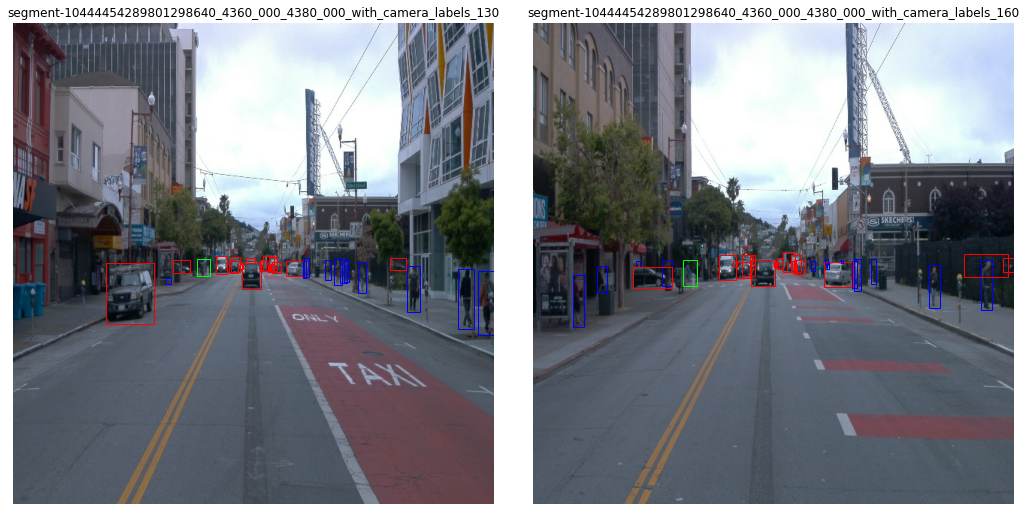

In [152]:
# pick a batch from the dataset
file_path = pick_random_dataset()
# file_path = "project/data/processed/segment-11839652018869852123_2565_000_2585_000_with_camera_labels.tfrecord" # highway scene
# file_path = "project/data/processed/segment-1191788760630624072_3880_000_3900_000_with_camera_labels.tfrecord" # suburban scene
# file_path = "project/data/processed/segment-10485926982439064520_4980_000_5000_000_with_camera_labels.tfrecord" # urban with cyclist and lots of pedestrians
# file_path = "project/data/processed/segment-10485926982439064520_4980_000_5000_000_with_camera_labels.tfrecord"

single_file_batch = generate_batch([file_path], frames_per_file=2)
display_instances(single_file_batch)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [155]:
# Print all keys for a single sample to get an impression of the contained data
sample = single_file_batch[0]
print_keys(sample)

image                              3d tensor
source_id                          segment-10444454289801298640_4360_000_4380_000_with_camera_labels_130.tfrecord
key                                
filename                           segment-10444454289801298640_4360_000_4380_000_with_camera_labels_130.tfrecord
groundtruth_image_confidences      []
groundtruth_verified_neg_classes   []
groundtruth_not_exhaustive_classes []
groundtruth_boxes                  2d tensor
groundtruth_area                   []
groundtruth_is_crowd               []
groundtruth_difficult              []
groundtruth_group_of               []
groundtruth_weights                [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
groundtruth_classes                [1 4 2 1 2 1 1 1 1 2 2 1 2 1 1 2 2 2 2 2 1 2 1 1 1 1 1 1 1 1]
groundtruth_image_classes          []
original_image_spatial_shape       [640 640]


Loaded segment-12027892938363296829_4086_280_4106_280_with_camera_labels.tfrecord
Loaded segment-10963653239323173269_1924_000_1944_000_with_camera_labels.tfrecord
Loaded segment-10927752430968246422_4940_000_4960_000_with_camera_labels.tfrecord
Loaded segment-11928449532664718059_1200_000_1220_000_with_camera_labels.tfrecord
Loaded segment-11967272535264406807_580_000_600_000_with_camera_labels.tfrecord
Loaded segment-10750135302241325253_180_000_200_000_with_camera_labels.tfrecord
Loaded segment-10724020115992582208_7660_400_7680_400_with_camera_labels.tfrecord
Loaded segment-11183906854663518829_2294_000_2314_000_with_camera_labels.tfrecord
Loaded segment-11126313430116606120_1439_990_1459_990_with_camera_labels.tfrecord
Loaded segment-10061305430875486848_1080_000_1100_000_with_camera_labels.tfrecord


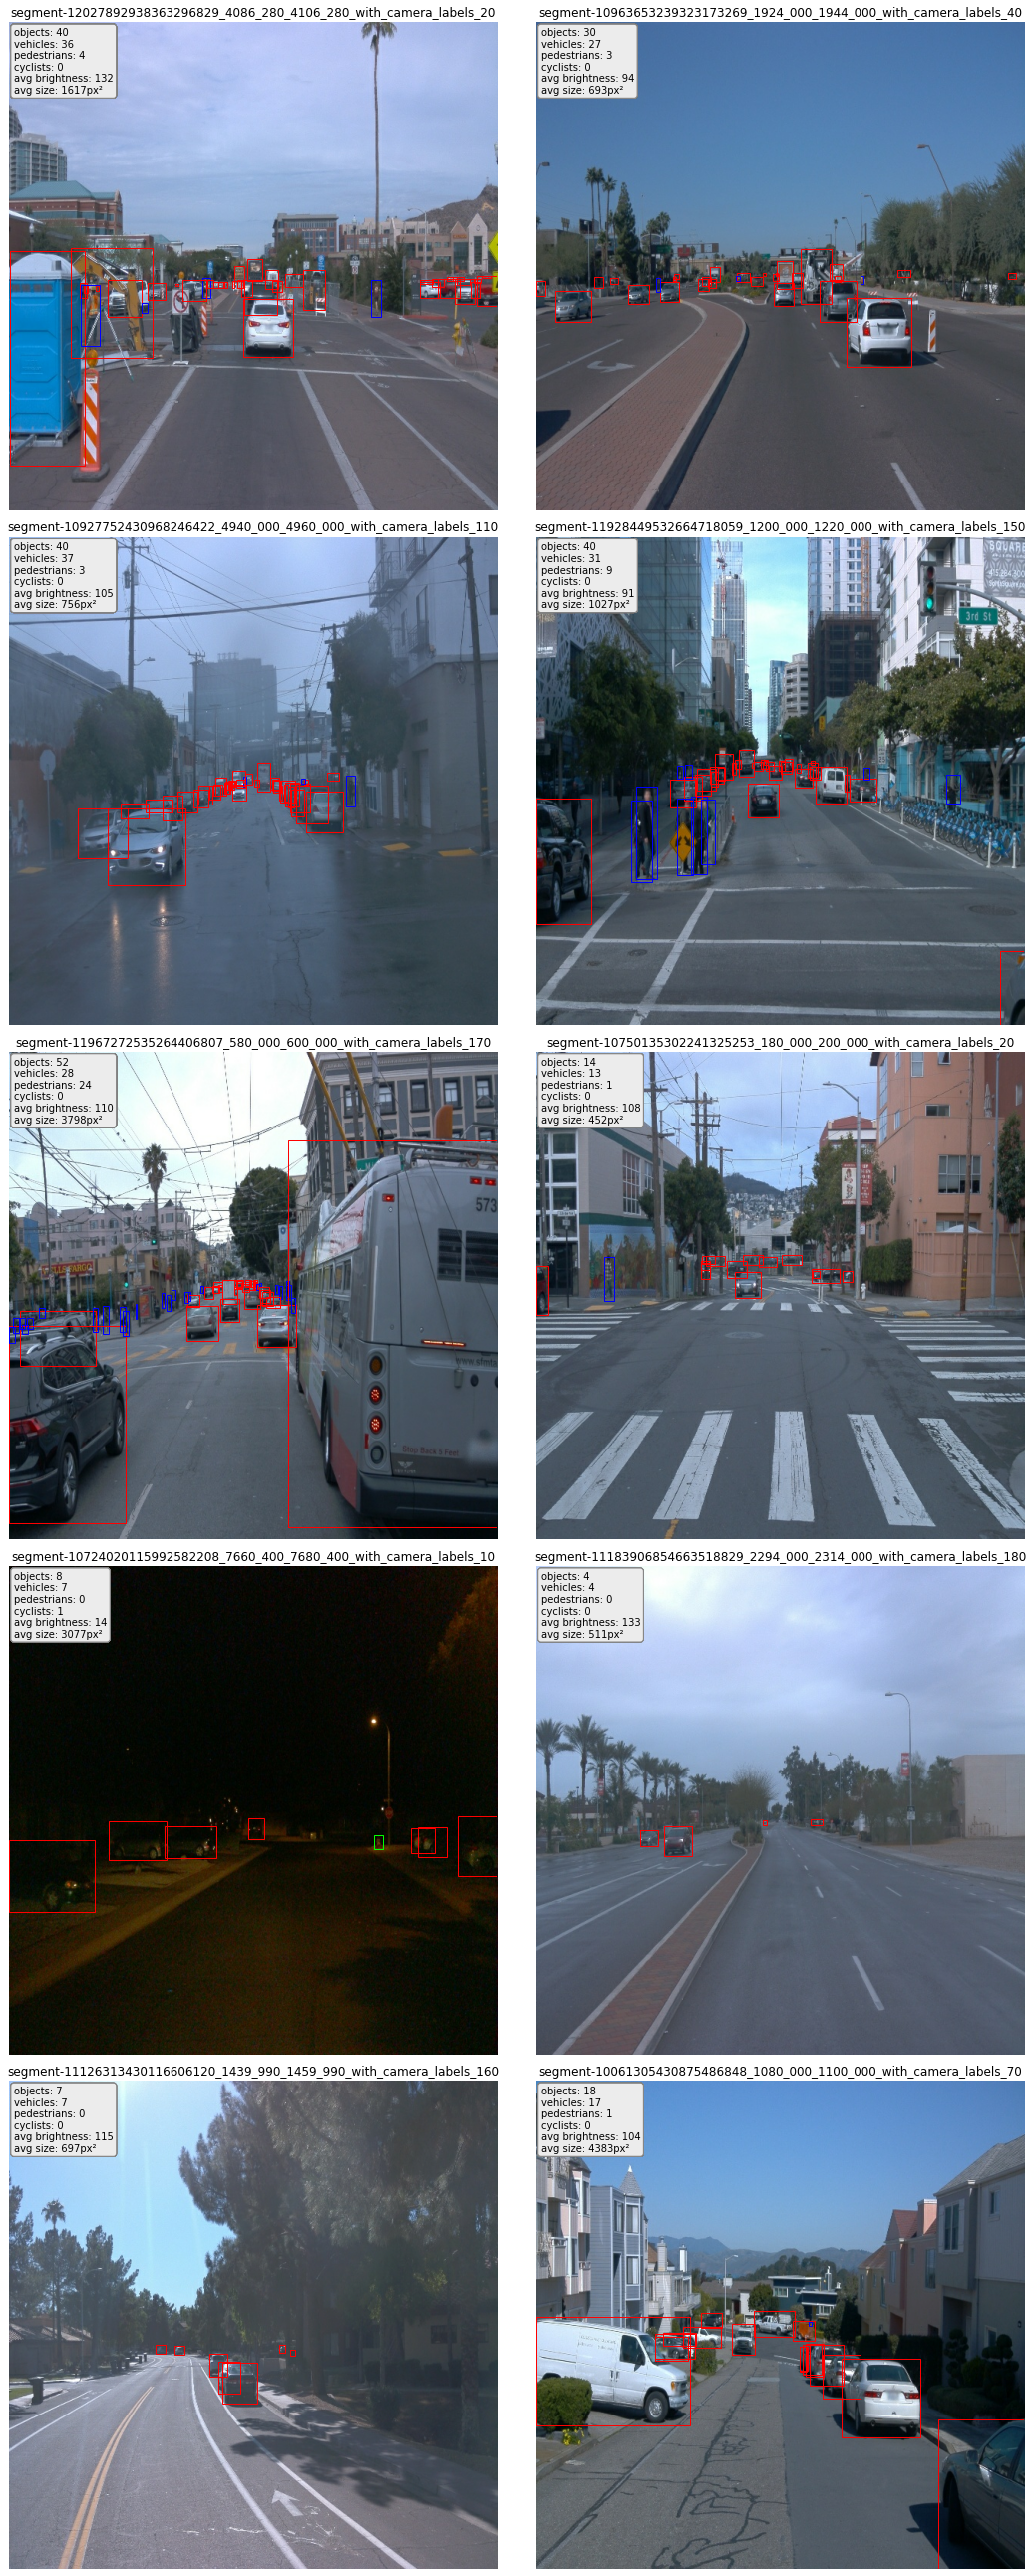

In [153]:
# plot a single frame from each dataset to get a wider impression
datasets = make_data_path()[0:10]
overview_batch = generate_batch(datasets)
display_instances(overview_batch, show_info=True)

In [62]:
# generate statistics of label distribution over whole dataset

# get a list with all .tfrecord files
data_path = make_data_path()

# number of samples (frames) to be taken from each .tfrecord
n_samples = 10

file_names = []
vehicle_avg_file = []
pedestrian_avg_file = []
cyclist_avg_file = []
sample_count_file = []

# Processing all frames from a single data file is expensive therefor draw n_samples and compute metrics
for file in data_path[0:5]:
    file_name = file.split('/')[-1]
    dataset = get_dataset(file, label_map="project/label_map.pbtxt")
    dataset.shuffle(buffer_size=1)
    
    vehicle_count = []
    pedestrian_count = []
    cyclist_count = []

    start_time = time.time()
    for i in range(n_samples):
        try:
            sample = iter(dataset).get_next()
            object_counts = count_objects_by_type(sample)
            vehicle_count.append(object_counts["vehicles"])
            pedestrian_count.append(object_counts["pedestrians"])
            cyclist_count.append(object_counts["cyclists"])
        except StopIteration:
            elapsed = time.time() - start_time
            sample_count = i+1
            print(f"Finised reading \t {file_name} with {sample_count} samples after {elapsed:.2f}s. (EOF)")
            break
    elapsed = time.time() - start_time
    sample_count = i+1
    print(f"Finished reading {file_name} after {sample_count} samples within {elapsed:.2f}s. (limit exceeded)")
    file_names.append(file_name)
    vehicle_avg_file.append(sum(vehicle_count) / sample_count)
    pedestrian_avg_file.append(sum(pedestrian_count) / sample_count)
    cyclist_avg_file.append(sum(cyclist_count) / sample_count)
    sample_count_file.append(sample_count)
    
df = pd.DataFrame(list(zip(file_names, sample_count_file, vehicle_avg_file, pedestrian_avg_file, cyclist_avg_file)), \
columns=["filename", "n_samples", "vehicles_avg", "pedestrians_avg", "cyclists_avg"])
df.loc[:,"objects_avg"] = df.loc[:,"vehicles_avg"] + df.loc[:,"pedestrians_avg"] + df.loc[:,"cyclists_avg"]
df.loc[:,"vehicles_avg_norm"] = df.loc[:,"vehicles_avg"] / df.loc[:,"objects_avg"]
df.loc[:,"pedestrians_avg_norm"] = df.loc[:,"pedestrians_avg"] / df.loc[:,"objects_avg"]
df.loc[:,"cyclists_avg_norm"] = df.loc[:,"cyclists_avg"] / df.loc[:,"objects_avg"]

df.describe()

Finished reading segment-12027892938363296829_4086_280_4106_280_with_camera_labels.tfrecord after 10 samples within 2.04s. (limit exceeded)
Finished reading segment-10963653239323173269_1924_000_1944_000_with_camera_labels.tfrecord after 10 samples within 2.25s. (limit exceeded)
Finished reading segment-10927752430968246422_4940_000_4960_000_with_camera_labels.tfrecord after 10 samples within 2.18s. (limit exceeded)
Finished reading segment-11928449532664718059_1200_000_1220_000_with_camera_labels.tfrecord after 10 samples within 3.22s. (limit exceeded)
Finished reading segment-11967272535264406807_580_000_600_000_with_camera_labels.tfrecord after 10 samples within 2.92s. (limit exceeded)


n_samples  vehicles_avg  pedestrians_avg  cyclists_avg  objects_avg  \
count        5.0      5.000000         5.000000      5.000000     5.000000   
mean        10.0     27.900000         9.180000      0.060000    37.140000   
std          0.0      8.678422         5.277499      0.134164     7.184915   
min         10.0     15.800000         2.800000      0.000000    29.400000   
25%         10.0     22.700000         4.800000      0.000000    32.700000   
50%         10.0     30.500000        10.000000      0.000000    35.300000   
75%         10.0     32.700000        13.300000      0.000000    40.600000   
max         10.0     37.800000        15.000000      0.300000    47.700000   

       vehicles_avg_norm  pedestrians_avg_norm  cyclists_avg_norm  
count           5.000000              5.000000           5.000000  
mean            0.742439              0.255520           0.002041  
std             0.156486              0.153176           0.004563  
min             0.537415              0.068966           0.000000  
25%             0.685535              0.135977           0.000000  
50%             0.694190              0.305810           0.000000  
75%             0.864023              0.314465           0.000000  
max             0.931034              0.452381           0.010204

In [27]:
# sample = single_file_batch[1]
# def calculate_avg_bbox_size(sample):
#     """Returns the average area of the bounding boxes of a sample(single frame)

#     Args:
#         - sample [tf.Dataset]: tensorflow dataset

#     Returns:
#         - int: Average area of bboxes in px**2
#     """
#     bboxes = 640 * sample["groundtruth_boxes"].numpy()
#     areas = []
#     for bbox in bboxes:
#         y1, x1, y2, x2 = bbox 
#         width = x2 - x1
#         height = y2 - y1  
#         areas.append(height * width)
#     return int(sum(areas) / len(areas))
# areas = calculate_avg_bbox_size(sample)
# print(areas)

1221


In [94]:


# sample = single_file_batch[1]
# def calculate_avg_brightness(sample):
#     """Calculates average brightness of the grayscale version of the sample.

#     Args:
#         - sample [tf.Dataset]: tensorflow dataset

#     Returns:
#         int: Average intensity of the grayscale sample
#     """
#     img = Image.fromarray(sample["image"].numpy())
#     gray_image = ImageOps.grayscale(img)
#     return int(np.array(gray_image).mean())
# img = calculate_avg_brightness(sample)

In [95]:
# img

119

Text(0, 0.5, 'Relative average class\n count per frame')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


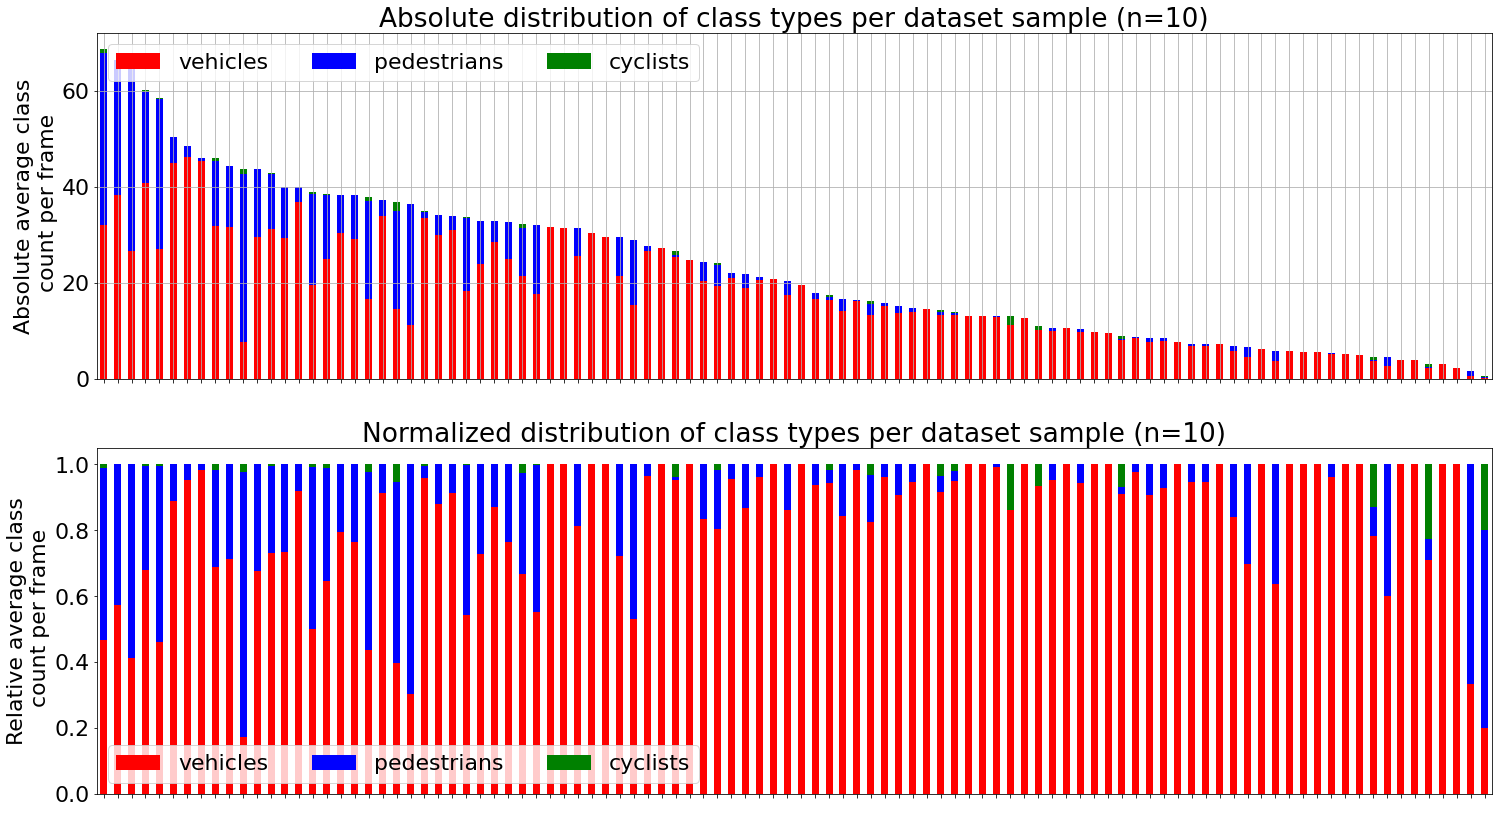

In [18]:
# plot the distribution of the classes
df_sorted = df.sort_values(by="objects_avg", ascending=False)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
plt.rc('font', **font)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(25,14))

df_sorted.loc[:,["vehicles_avg", "pedestrians_avg", "cyclists_avg"]].plot(kind='bar', ax = axes[0], stacked=True, color="rbg")
df_sorted.loc[:,["vehicles_avg_norm", "pedestrians_avg_norm", "cyclists_avg_norm"]].plot(kind='bar', ax = axes[1], stacked=True, color="rbg")

for ax in axes:
        # ax.set_xlabel("Individual dataset")
        ax.set_xticklabels([])
        
axes[0].legend(["vehicles", "pedestrians", "cyclists"], ncol=3, loc="upper left")
axes[1].legend(["vehicles", "pedestrians", "cyclists"], ncol=3, loc="lower left")

axes[0].grid()

axes[0].set_title(f"Absolute distribution of class types per dataset sample (n={n_samples})")
axes[0].set_ylabel("Absolute average class\n count per frame")
axes[1].set_title(f"Normalized distribution of class types per dataset sample (n={n_samples})")
axes[1].set_ylabel("Relative average class\n count per frame")
